In [1]:
"""
Model
"""
import os
import csv
import math
import numpy as np
import cv2
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Activation, Dropout, Conv2D, Flatten, MaxPooling2D, Convolution2D
from keras.layers.advanced_activations import ELU
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


/home/anand/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/anand/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


NumSamples: 75648, Shape:(1, 66, 200, 3)


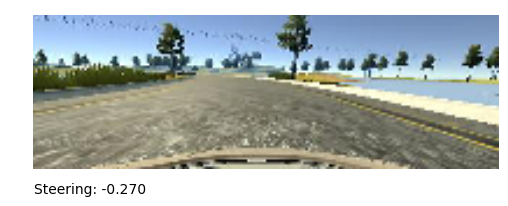

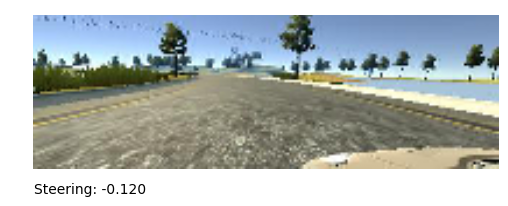

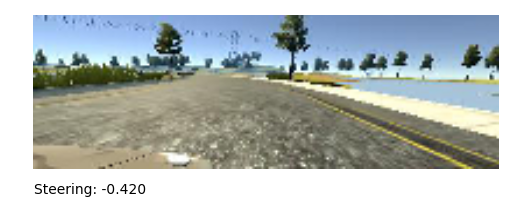

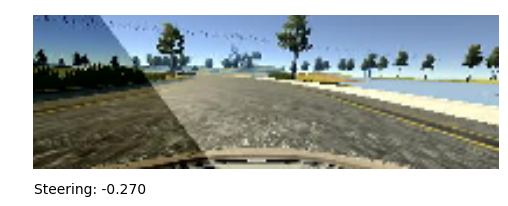

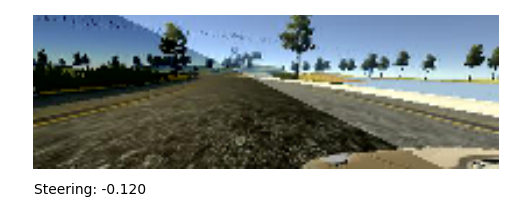

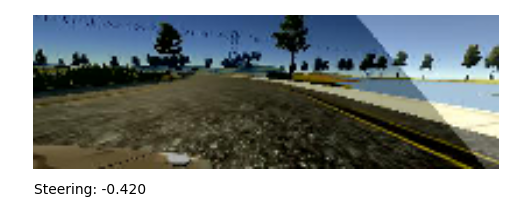

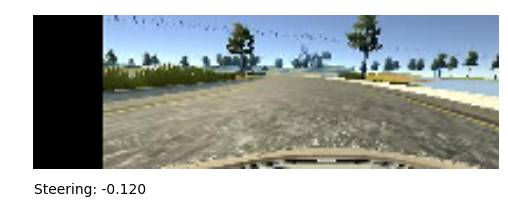

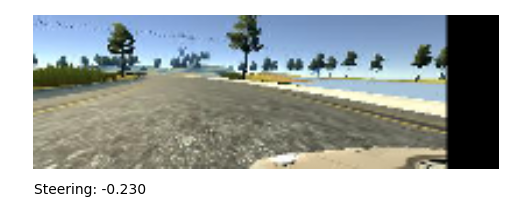

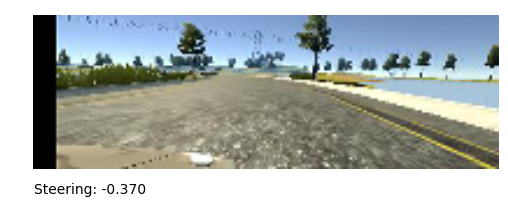

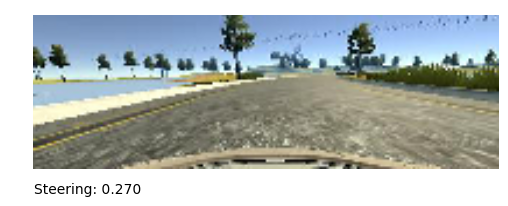

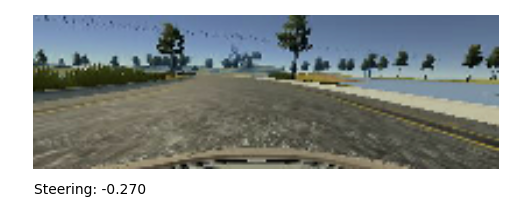

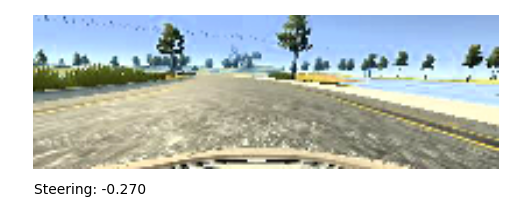

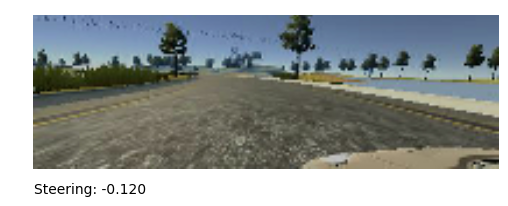

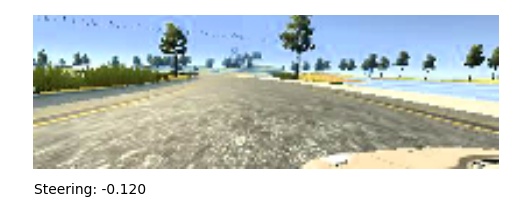

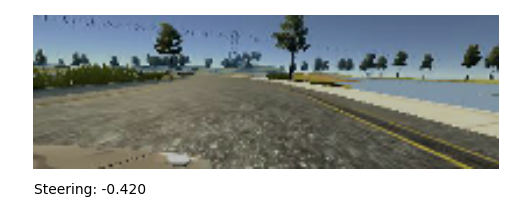

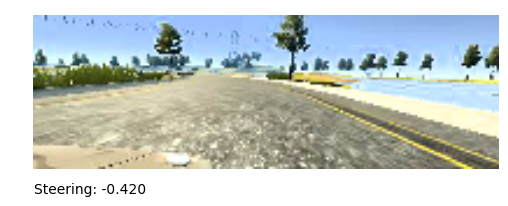

In [2]:
LABELS_FILENAME = 'data/driving_log.csv'

"""
Functions for training
"""
# generate training data in an infinite loop - called from keras fit_generator
def genTrainingData(data):
    while True:
        data = shuffle(data)
        src = genNormalizedData(genAugmentedViews(data))
        for sample in src:
            yield sample

# enumerate rows of csv data - returns raw row contents
def enumDrivingLog(driving_log_fname):
    with open(driving_log_fname, 'r') as labels_file:
        rdr=csv.DictReader(labels_file)
        for row in rdr:
            yield row

# filter out some rows (based on keepPercentage) with low steering values (based on threshold)
def filterDrivingLog(src, threshold, keepPercentage):
    for row in src:
        steering = float(row['steering'])
        if abs(steering) > threshold or np.random.randint(0,100) <= keepPercentage:
            yield row

# generate images that supplement the data set
def genAugmentedViews(src):
    for row in src:
        steering = float(row['steering'])
        center = readImage(row['center'])
        left = readImage(row['left'])
        right = readImage(row['right'])
        
        # center camera image
        yield (center, steering)
        
        # adjust steering for left and right cameras
        left_steer = np.clip(steering + 0.15, -1, 1)        
        right_steer = np.clip(steering - 0.15, -1, 1)
        yield (left, left_steer)
        yield (right, right_steer)

        # add random shadows to center, right and left cameras
        yield (addShadow(center), steering)
        yield (addShadow(left), left_steer)
        yield (addShadow(right), right_steer)
        
        # add random shifts
        yield addShift(center, steering)
        yield addShift(left, left_steer)
        yield addShift(right, right_steer)

        # flip center camera image
        yield (cv2.flip(center, 1), steering * -1.)

        # vary image brightness on each camera - to half and third of the original brightness
        yield (adjustBrightness(center, .75), steering)
        yield (adjustBrightness(center, 1.25), steering)
        yield (adjustBrightness(left, .75), left_steer)
        yield (adjustBrightness(left, 1.25), left_steer)
        yield (adjustBrightness(right, .75), right_steer)
        yield (adjustBrightness(right, 1.25), right_steer)


def addShift(img, steering):
    axis = 1
    amt = float(np.random.randint(-img.shape[axis]//5,img.shape[axis]//5+1))
    sImg = np.zeros(img.shape,dtype=np.uint8)

    steer_inc = -amt / img.shape[axis]
    #print("Steering: %.3f, Inc: %.3f" %(steering, steer_inc))
    steering += steer_inc
    
    if amt < 0:
        amt = abs(amt)
        sImg[:,amt:img.shape[axis]] = img[:,0:img.shape[axis]-amt]
    else:
        sImg[:,0:img.shape[axis]-amt] = img[:,amt:img.shape[axis]]

    return sImg,steering

# adds a random shadow to a given image
def addShadow(img):
    y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    y = y.astype(np.int32)
    # create mask image
    mask = np.zeros(y.shape, dtype=np.int32)
    # compute line in slope, intercept form
    x1 = np.random.uniform() * y.shape[1]
    x2 = np.random.uniform() * y.shape[1]
    slope = float(y.shape[0]) / (x2 - x1)
    intercept = -(slope * x1)
    # assign pixels of mask
    for j in range(mask.shape[0]):
        for i in range(mask.shape[1]):
            if j > (i*slope)+intercept:
                mask[j,i] -= 80
    # apply mask
    y += mask
    y = np.clip(y, 0,255).astype(np.uint8)
    return cv2.cvtColor(cv2.merge((y,u,v)), cv2.COLOR_YCrCb2RGB)

# adjust brightness of given image (img) by multiplyling V
def adjustBrightness(img, m):
    h,s,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    v = np.clip(v * m, 0, 255).astype(np.uint8)
    return cv2.cvtColor(cv2.merge((h,s,v)), cv2.COLOR_HSV2RGB)

# normalize image and steering data
# round out steering values to fall in 0.01 buckets (so problem is simplified, could even become classification problem)
# keras requires np.array for y values: convert steering to 1D np.array
def genNormalizedData(src):
    for img,steering in src:
        # round and convert from -1 : +1 to -0.5 : + 0.5
        #normSteering = round(steering,2) / 2.
        normSteering = round(steering,2)
        x = normalizeImage(img)
        y = np.array(normSteering, ndmin=1, dtype=np.float)
        yield x,y
        
"""
Operations done for every image - both training and predictions
"""
# retrive image data from disk
# returns image in RGB format
def readImage(img_fname):
    img_path = os.path.join('data',img_fname.strip())
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# convert RGB to YUV
def convColorSpace2YUV(img):
    y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    return cv2.merge((y,u,v))

# convert RGB to gray (keep 3rd dim as 1)
def convColorSpace2Gray(img):
    y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
    return y.reshape(*y.shape,1)

# crop 5th off top and 25px off bottom of given image
def cropImage(img):
    ht = img.shape[0]
    cropHt = ht // 5
    return img[cropHt:ht-25, :]

# normalize image data
# convert to y,u,v
# crop to remove top 5th and bottom 5th of image
# adjust pixel values to fall within -1 to +1
# keras requires 4d-tensor input: add dimension 1, h,w,d for image data
def normalizeImage(img):
    croppedImg = cropImage(img)
    resizedImg = cv2.resize(croppedImg, (200,66), interpolation = cv2.INTER_CUBIC)
    yuvImg = convColorSpace2YUV(resizedImg)
    nImg = ((yuvImg / 127.5) - 1.).astype(np.float32)
    x = nImg.reshape(1,*nImg.shape)
    return x

# de-normalize image data to RGB format for display
def imgForDisplay(img):
    img = ((img + 1.) * 127.5).astype(np.uint8)
    img = img.reshape(img.shape[1:4])
    if img.shape[2] == 3: #yuv
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    elif img.shape[2] == 1: #grayscale
        img = img.reshape(img.shape[0:2])
    return img

data = list(filterDrivingLog(enumDrivingLog(LABELS_FILENAME), 0.01, 25))

# split into train and validation
#train, test = train_test_split(data, test_size=0.25)
train = shuffle(data)

sampleIdx = 0
while float(train[sampleIdx]['steering']) == 0.:
    sampleIdx += 1

imageGenerator = genNormalizedData(genAugmentedViews([train[sampleIdx]]))
imgListExample = list(imageGenerator)
numImagesPerSample = len(imgListExample)
numRows = len(train) * numImagesPerSample
exampleImg = imgListExample[0][0]
image_shape = exampleImg.shape
print("NumSamples: {0}, Shape:{1}".format(numRows, image_shape))

for normImg,normSteering in imgListExample:
    plt.figure()
    plt.axis('off')
    img = imgForDisplay(normImg)
    ht = img.shape[0]+10
    steering = normSteering # * 2.
    if len(img.shape) == 3: # rgb
        plt.imshow(img)
    else: # grayscale
        plt.imshow(img, cmap='gray')
    plt.text(0,ht,'Steering: %.3f' % steering)


In [3]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode='same', init='he_normal', input_shape=image_shape[1:4]))
    model.add(ELU())
    
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode='same', init='he_normal'))
    model.add(ELU())
    
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), border_mode='valid', init='he_normal'))
    model.add(ELU())
    
    model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode='valid', init='he_normal'))
    model.add(ELU())
    
    model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode='valid', init='he_normal'))
    model.add(ELU())
    
    model.add(Flatten())
    
    model.add(Dense(100, init='he_normal'))
    model.add(ELU())
    
    model.add(Dense(50, init='he_normal'))
    model.add(ELU())
    
    model.add(Dense(10, init='he_normal'))
    model.add(ELU())
    
    model.add(Dense(1, init='he_normal'))
    
    return model
    
def myModel():    
    model = Sequential()

    model.add(Conv2D(8, 5, 5, input_shape=image_shape[1:4]))
    model.add(MaxPooling2D((2,2)))
    #model.add((Dropout(0.5)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(16, 5, 5))
    model.add(MaxPooling2D((2,2)))
    #model.add((Dropout(0.5)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, 5, 5))
    model.add(MaxPooling2D((2,2)))
    #model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Conv2D(64, 3, 3))
    model.add(MaxPooling2D((1,1)))
    #model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Conv2D(128, 3, 3))
    model.add(MaxPooling2D((1,1)))
    #model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='softmax'))
    return model

MODEL_FILE = 'data/model.h5'
if os.path.exists(MODEL_FILE):
    print("Loading from file")
    model = load_model(MODEL_FILE)
else:
    print("Creating model")
    model = nvidia_model()
model.summary()

Creating model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 33, 100, 24)   1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 33, 100, 24)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 17, 50, 36)    21636       elu_1[0][0]                      
____________________________________________________________________________________________________
elu_2 (ELU)                      (None, 17, 50, 36)    0           convolution2d_2[0][0]            
____________________________________________________________________________

In [4]:
# TODO: Compile and train the model here.
from keras.optimizers import SGD, Adam
#optimizer = SGD(lr=0.0001)
optimizer = Adam(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
history = model.fit_generator(genTrainingData(train), samples_per_epoch=numRows, nb_epoch=5, verbose=1, max_q_size=100)

Epoch 1/5


/home/anand/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/anand/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


75648/75648 [==============================] - 687s - loss: 0.0149 - acc: 0.0926   
Epoch 2/5
75648/75648 [==============================] - 684s - loss: 0.0123 - acc: 0.0927   
Epoch 3/5
75648/75648 [==============================] - 685s - loss: 0.0115 - acc: 0.0926   
Epoch 4/5
54804/75648 [====================>.........] - ETA: 188s - loss: 0.0118 - acc: 0.0932

KeyboardInterrupt: 

In [5]:
model.save(MODEL_FILE)